# Jorge Carnicero Prícipe - Análisis Predictivo del Rendimiento Académico

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from collections import defaultdict
from scipy.stats import f_oneway

from LinearRegressor import *
from funciones_prediccion import *

In [2]:
DIR_TRAIN = "data/rendimiento_estudiantes_train.csv"
DIR_TEST = "data/rendimiento_estudiantes_test_vacio.csv"

In [3]:
df = pd.read_csv(DIR_TRAIN)
df.columns

Index(['escuela', 'sexo', 'edad', 'entorno', 'TamFam', 'EstPadres', 'Medu',
       'Pedu', 'Mtrab', 'Ptrab', 'razon', 'tutor', 'TiempoViaje',
       'TiempoEstudio', 'suspensos', 'apoyo', 'ApFam', 'academia', 'extras',
       'enfermeria', 'EstSup', 'internet', 'pareja', 'RelFam', 'TiempoLib',
       'SalAm', 'AlcSem', 'AlcFin', 'salud', 'faltas', 'asignatura', 'T1',
       'T2', 'T3'],
      dtype='object')

## Análisis Previo

In [4]:
from funciones_limpiar import *

Limpiar Nulos

In [5]:
df.isna().sum()[df.isna().sum() > 0]

Medu              52
Pedu             104
TiempoEstudio     16
RelFam            17
AlcSem            20
dtype: int64

In [6]:
df = computar_nulos(df)
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

Limpiar los otras en la columna de razon

In [7]:
print(df["razon"].value_counts())
df = computar_otras_en_razon(df)
print("=======================")
print(df["razon"].value_counts())

razon
optativas     348
cercania      204
reputacion    198
otras          56
otros          29
Name: count, dtype: int64
razon
optativas     348
cercania      204
reputacion    198
otras          85
Name: count, dtype: int64


Ver outliers

Vemos como en faltas hay muchisimos outliers, y además si nos informamos un poco vemos como hay algunas imposibles ya que el calendario académico dicta entre 175 a 180 días lectivos

In [ ]:
df = computar_outliers_faltas(df,df["faltas"].median())

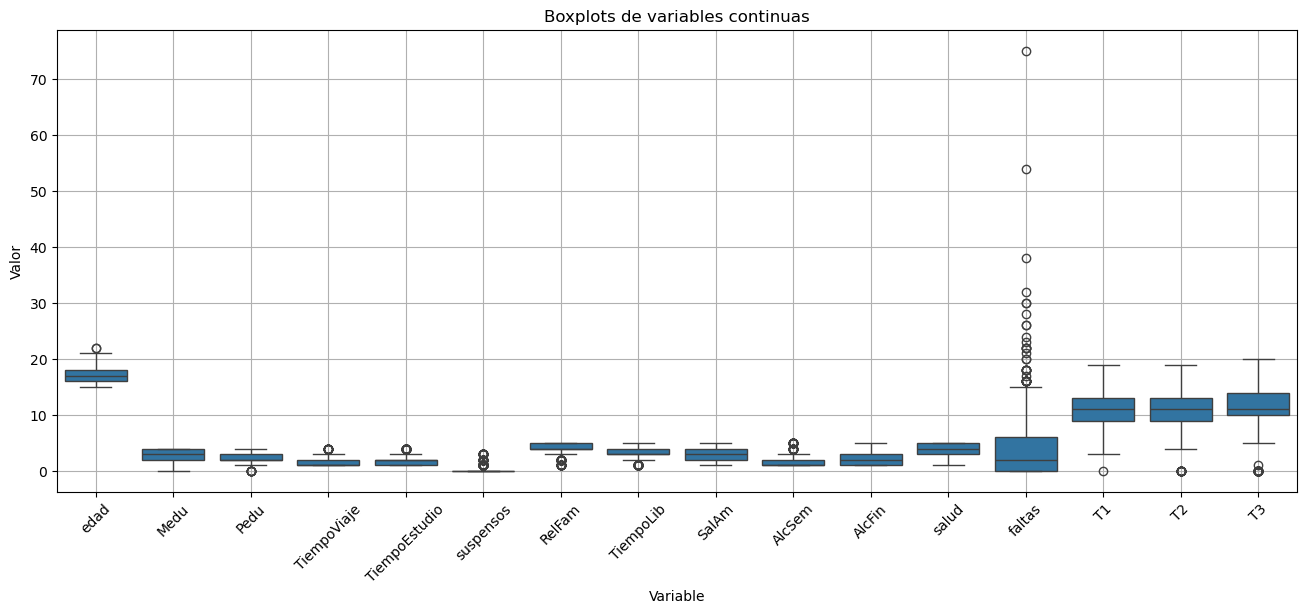

In [10]:
# Subset del DataFrame solo con esas columnas
data = df.select_dtypes(include=["number"])

# Convertimos a formato largo para usar con seaborn
data_long = data.melt(var_name='Variable', value_name='Valor')

plt.figure(figsize=(16, 6))
sns.boxplot(x='Variable', y='Valor', data=data_long)
plt.title('Boxplots de variables continuas')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Ahora una vez hemos limpiado el df vamos a investigar un poco

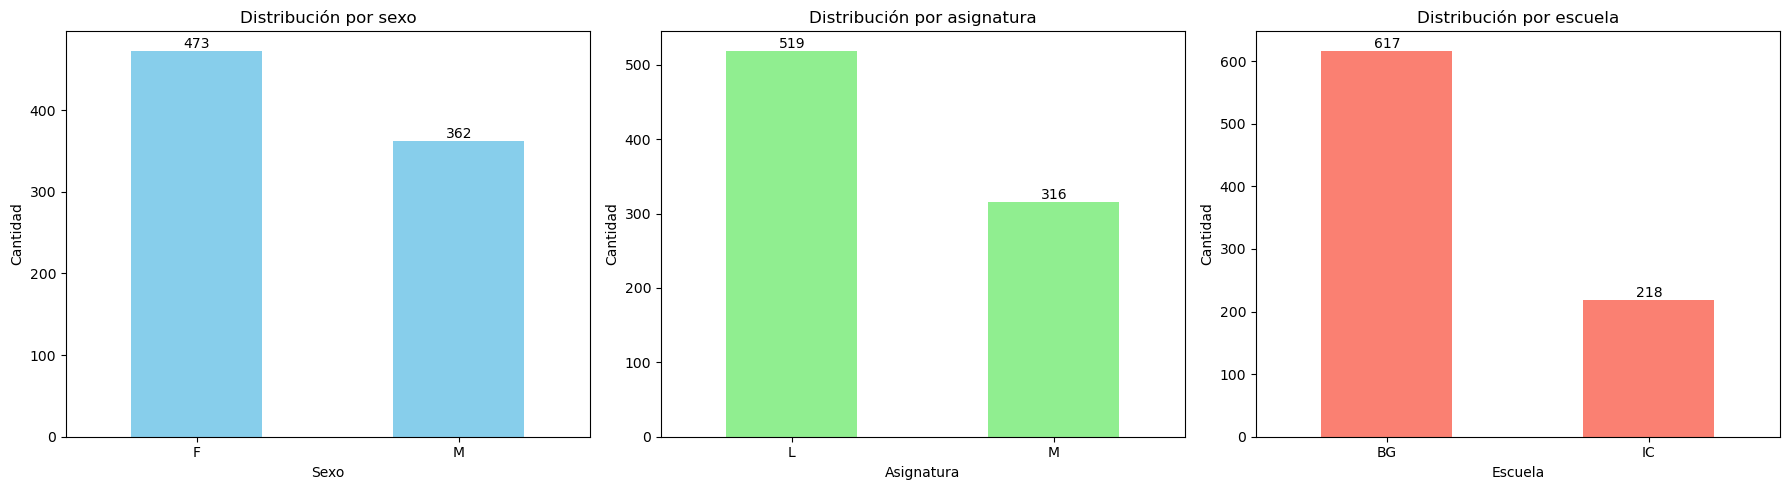

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Una fila, tres columnas

# Función para agregar etiquetas arriba de cada barra
def add_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2, height),
                    ha="center", va="bottom", fontsize=10)

# Histograma para "sexo"
df["sexo"].value_counts().plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Distribución por sexo")
axes[0].set_xlabel("Sexo")
axes[0].set_ylabel("Cantidad")
axes[0].tick_params(axis="x", rotation=0)
add_labels(axes[0])

# Histograma para "asignatura"
df["asignatura"].value_counts().plot(kind="bar", ax=axes[1], color="lightgreen")
axes[1].set_title("Distribución por asignatura")
axes[1].set_xlabel("Asignatura")
axes[1].set_ylabel("Cantidad")
axes[1].tick_params(axis="x", rotation=0)
add_labels(axes[1])

# Histograma para "escuela"
df["escuela"].value_counts().plot(kind="bar", ax=axes[2], color="salmon")
axes[2].set_title("Distribución por escuela")
axes[2].set_xlabel("Escuela")
axes[2].set_ylabel("Cantidad")
axes[2].tick_params(axis="x", rotation=0)
add_labels(axes[2])

plt.tight_layout()
plt.show()

In [12]:
# Ver cuántos datos tiene cada escuela
df["escuela"].value_counts()

# Obtener el mínimo número de registros entre escuelas
min_count = df["escuela"].value_counts().min()

# Tomar aleatoriamente min_count muestras de cada escuela
df_balanced = df.groupby("escuela").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

C:\Users\Estudios\AppData\Local\Temp\ipykernel_26364\3877097423.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("escuela").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


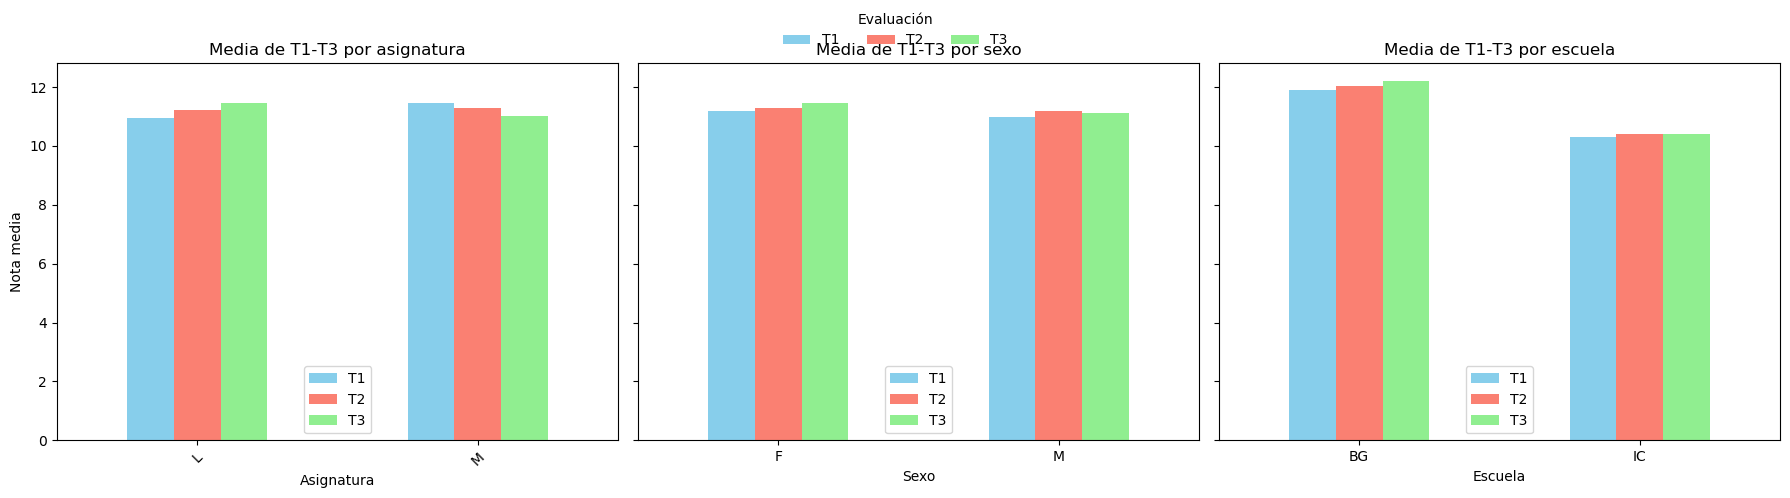


p‑value ANOVA Sexo vs T1: 0.5242066070088574
p‑value ANOVA Sexo vs T2: 0.7671242188702166

p‑value ANOVA Escuela vs T1: 8.850002512327429e-08
p‑value ANOVA Escuela vs T2: 3.293853973142361e-07

p-value ANOVA Asignatura vs T1: 0.12628133442016062
p-value ANOVA Asignatura vs T2: 0.8448048169860047


In [13]:
# --- 1) Medias agrupadas ------------------------------------------------
media_asig   = df_balanced.groupby("asignatura")[["T1", "T2", "T3"]].mean()
media_sexo   = df_balanced.groupby("sexo")      [["T1", "T2", "T3"]].mean()
media_esc    = df_balanced.groupby("escuela")   [["T1", "T2", "T3"]].mean()

# --- 2) Subplots en la misma figura -------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# a) Asignatura
media_asig.plot(kind="bar", ax=axes[0],
                color=["skyblue", "salmon", "lightgreen"])
axes[0].set_title("Media de T1‑T3 por asignatura")
axes[0].set_xlabel("Asignatura")
axes[0].set_ylabel("Nota media")
axes[0].tick_params(axis="x", rotation=45)

# b) Sexo
media_sexo.plot(kind="bar", ax=axes[1],
                color=["skyblue", "salmon", "lightgreen"])
axes[1].set_title("Media de T1‑T3 por sexo")
axes[1].set_xlabel("Sexo")
axes[1].tick_params(axis="x", rotation=0)

# c) Escuela
media_esc.plot(kind="bar", ax=axes[2],
               color=["skyblue", "salmon", "lightgreen"])
axes[2].set_title("Media de T1‑T3 por escuela")
axes[2].set_xlabel("Escuela")
axes[2].tick_params(axis="x", rotation=0)

# leyenda compartida
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Evaluación",
           loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # deja hueco para la leyenda arriba
plt.show()

# --- 3) ANOVAs -----------------------------------------------------------
# a) Sexo vs T1/T2
grupos_sexo_T1 = [g["T1"].dropna() for _, g in df_balanced.groupby("sexo")]
grupos_sexo_T2 = [g["T2"].dropna() for _, g in df_balanced.groupby("sexo")]
print()
print("p‑value ANOVA Sexo vs T1:", f_oneway(*grupos_sexo_T1).pvalue)
print("p‑value ANOVA Sexo vs T2:", f_oneway(*grupos_sexo_T2).pvalue)

# b) Escuela vs T1/T2 (opcional, mismo patrón)
grupos_esc_T1 = [g["T1"].dropna() for _, g in df_balanced.groupby("escuela")]
grupos_esc_T2 = [g["T2"].dropna() for _, g in df_balanced.groupby("escuela")]
print()
print("p‑value ANOVA Escuela vs T1:", f_oneway(*grupos_esc_T1).pvalue)
print("p‑value ANOVA Escuela vs T2:", f_oneway(*grupos_esc_T2).pvalue)

# Agrupar por asignatura y obtener las notas T1 y T2 para cada grupo
grupos_asignatura_T1 = [grupo["T1"].dropna() for _, grupo in df_balanced.groupby("asignatura")]
grupos_asignatura_T2 = [grupo["T2"].dropna() for _, grupo in df_balanced.groupby("asignatura")]

# Realizar ANOVA
anova_asignatura_T1 = f_oneway(*grupos_asignatura_T1)
anova_asignatura_T2 = f_oneway(*grupos_asignatura_T2)
print()
print("p-value ANOVA Asignatura vs T1:", anova_asignatura_T1.pvalue)
print("p-value ANOVA Asignatura vs T2:", anova_asignatura_T2.pvalue)

## MODEL I

### Modelo - Linear Regresion

Preparamos los datos que vamos a usar para el primer modelo, el modelo de regresión lineal

In [14]:
df = pd.read_csv(DIR_TRAIN)
df_new = limpieza_total(df)

X_train, y_train, X_test, y_test = dividir_df_train_test(df_new,test_size=0.3,random_state=16)

creamos y entrenamos el modelo

In [ ]:
modelo = LinearRegressor()  

entrenamos el modelo y predecimos los valores de validación para luego ver el rendimiento de nuestro modelo

In [16]:
# Creamos y entrenamos el model
modelo.fit(X_train, y_train)

# Predecimos
# y_pred_val = modelo.predict(X_test[["T1","T2"]])
y_pred_val = modelo.predict(X_test)
y_pred_val_capeado = np.round(np.clip(y_pred_val, 0, 20))

Comprobamos el rendimiento de nuestro primer modelo

In [17]:
evaluate_regression(y_pred_val,y_test)

{'R2': 0.8614107544920834,
 'RMSE': 1.347497533821802,
 'MAE': 0.9311058854342618}

Vemos cuales son las variables que mayor peso tienen

In [18]:
coef_df = pd.DataFrame({
    'Variable':  list(X_train.columns),
    'Coeficiente': modelo.coefficients
})

print(coef_df.sort_values(by="Coeficiente"))

            Variable  Coeficiente
41      asignatura_M    -0.656466
5          suspensos    -0.381087
39       internet_si    -0.344430
18        TamFam_>=4    -0.292368
37     enfermeria_si    -0.193975
16            sexo_M    -0.182408
19       EstPadres_S    -0.108391
21       Mtrab_otros    -0.093010
4      TiempoEstudio    -0.087685
40         pareja_si    -0.074984
9             AlcSem    -0.058491
11             salud    -0.053271
24    Ptrab_docencia    -0.036337
29       razon_otras    -0.033919
15        escuela_IC    -0.027135
3        TiempoViaje    -0.025895
0               edad    -0.024967
34          ApFam_si    -0.008632
8              SalAm     0.000117
1               Medu     0.016656
2               Pedu     0.025292
20    Mtrab_docencia     0.027586
38         EstSup_si     0.031873
7          TiempoLib     0.033179
36         extras_si     0.042336
12            faltas     0.049439
10            AlcFin     0.050023
35       academia_si     0.065178
6             

Predicción final

In [19]:
df_pred = pd.read_csv(DIR_TEST)

X_pred = limpieza_total(df_pred)

X_pred = X_pred.drop(columns=["T3"])

y_pred_modelo_1 = modelo.predict(X_pred)
# print(X_pred[["T1","T2"]])
y_pred_capeado_modelo_1 = np.round(np.clip(y_pred_modelo_1, 0, 20))
print(y_pred_capeado_modelo_1)

[ 7. 15. 12. 11. 14. 14.  9. 10. 15.  9. 13. 11.  6. 13.  9.  8. 12. 14.
 10. 12. 13. 10. 12. 12. 11. 14.  9. 12.  9. 12. 10. 13. 14.  8.  0. 10.
 10. 10. 13.  9. 13.  4. 14. 10. 12. 13. 13. 10.  0. 18.  9. 17. 10. 11.
 14.  6. 10. 14. 14. 10.  7. 15.  8.  6. 15. 13. 13.  9. 10. 13. 10. 19.
 13. 14.  6.  7.  5. 10. 14.  8. 11.  8. 11. 19. 11. 11.  9. 11. 14.  0.
 12. 12. 15.  9. 10. 16. 12. 10.  4. 11. 12.  8. 14.  8. 10. 14.  9. 12.
  7. 16. 13. 10.  9. 12. 13. 15.  8. 11. 12. 14.  8.  9. 13.  8. 19. 12.
 13. 11. 11.  9. 14. 12. 10. 14.  7. 18. 12. 11. 16.  6. 10. 16. 12. 14.
 11. 13. 10.  9. 10. 13. 13. 11. 12. 13. 10.  8. 13. 18.  9. 14. 14. 13.
 11. 15. 17. 10. 10.  8. 10.  8. 13. 10.  7.  8. 12. 15. 14. 12. 13. 12.
  6. 14. 10. 14. 13. 12. 14. 15. 18. 16. 13. 15. 10. 16.  9. 11. 13. 11.
 12. 10. 13. 11. 13. 12. 10. 13.  9. 11.  9.]


### Modelo 1 - Random Forest

Importamos lo necesario para realizar el random forest

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode


# ML libraries to construct, use and analyse the trees
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from io import StringIO
from IPython.display import Image  
from sklearn.metrics import mean_squared_error, confusion_matrix, root_mean_squared_error
from sklearn.metrics import mean_squared_error

Preparamos los datos necesarios para este segundo modelo

In [21]:
df = pd.read_csv(DIR_TRAIN)
df_new = limpieza_total(df)

X_train, y_train, X_test, y_test = dividir_df_train_test(df_new,test_size=0.3,random_state=16)

Realizamos el Random Forest sobre el conjunto de validación para luego evaluar y ver que tan bien lo hace

In [22]:
# RF parameters
n_estimators = 100 # Number of decision trees in the forest
max_features = 1  # Proportion of features to consider for each split

# Train decision trees with random feature selection and make predictions
tipo = 'clas'
predictions = []
for _ in range(n_estimators):

    # TODO: Construct your own RF ensemble! Reuse the Bagging code and change whatever you may need here
    n_samples = int(max_features * len(X_train))
    sample_indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True)  
    X_bootstrap = X_train.iloc[sample_indices]
    y_bootstrap =y_train.iloc[sample_indices] 

    # Train a decision tree classifier on the sample
    max_features_int = int(max_features * X_train.shape[1]) 
    decision_tree = DecisionTreeClassifier(max_features=max_features_int)
    decision_tree.fit(X_bootstrap, y_bootstrap)
    
    # Make predictions on the test set using the trained decision tree
    y_pred = decision_tree.predict(X_test) 
    predictions.append(y_pred)


# TODO: Finally, combine predictions using majority voting
combined_predictions = np.array(predictions)
if tipo == 'clas':
    majority_vote = mode(combined_predictions, axis=0).mode[0]
else:
    majority_vote = np.mean(combined_predictions,axis = 0) #media por elementos de la lista

print(majority_vote)
y_pred_final = combined_predictions[majority_vote]

8


Evaluamos que tan bien lo hace el Random Forest

In [23]:
evaluate_regression(y_pred_final,y_test)

{'R2': 0.8136203271444353, 'RMSE': 1.4463747785411636, 'MAE': 0.924}

## MODEL II

### Modelo - Linear Regresion

Preparamos los datos, que vamos a usar para tanto el entrenamiento como la validación del modelo

In [24]:
df = pd.read_csv(DIR_TRAIN)
df_new = limpieza_total(df)
df_new = df_new.drop(columns=["T1","T2"])
X_train, y_train, X_test, y_test = dividir_df_train_test(df_new,test_size=0.3,random_state=15)
print(y_train)

250    14
251    11
252    13
253    11
254    12
       ..
830    10
831     6
832    11
833    14
834    10
Name: T3, Length: 585, dtype: int64


Generamos el modelo de LinearRegressor y lo entrenamos, además de predecir el conjunto de validación

In [25]:
# Creamos y entrenamos el modelo
modelo = LinearRegressor()  # Aumentamos max_iter

modelo.fit(X_train, y_train)

# Predecimos
y_pred_val = modelo.predict(X_test)
y_pred_val_capeado = np.round(np.clip(y_pred_val, 0, 20))
# print(y_test,y_test)

Evaluamos el modelo para ver que tan bien predice y que tanto se va.

In [26]:
evaluate_regression(y_test,y_pred_val_capeado)

{'R2': 0.2637037578781226, 'RMSE': 3.4525353003264136, 'MAE': 2.416}

Ver un poco cuales son las variables que más afectan en nuestro modelo

In [27]:
coef_df = pd.DataFrame({
    'Variable':  list(X_train.columns),
    'Coeficiente': modelo.coefficients
})

print(coef_df.sort_values(by="Coeficiente"))

            Variable  Coeficiente
5          suspensos    -1.657911
31          apoyo_si    -1.293153
39      asignatura_M    -1.287305
25   Ptrab_servicios    -1.015037
13        escuela_IC    -0.899233
16        TamFam_>=4    -0.661254
23       Ptrab_otros    -0.578347
27       razon_otras    -0.447779
19       Mtrab_otros    -0.428525
38         pareja_si    -0.428462
18    Mtrab_docencia    -0.379510
32          ApFam_si    -0.306589
14            sexo_M    -0.295887
33       academia_si    -0.283385
11             salud    -0.246191
8              SalAm    -0.223949
26   razon_optativas    -0.216406
9             AlcSem    -0.142773
3        TiempoViaje    -0.106582
34         extras_si    -0.100727
0               edad    -0.066182
35     enfermeria_si    -0.045191
7          TiempoLib    -0.007543
12            faltas     0.004022
2               Pedu     0.030094
10            AlcFin     0.081989
28  razon_reputacion     0.114028
1               Medu     0.160922
37       inter

### Modelo - Random Forest

Realizamos el Random Forest

In [28]:
n_estimators = 300
max_features = 1
max_samples = 1

# Donde se guardan predicciones y contribuciones
predictions = []
importancia_total = defaultdict(list)

# Construimos el bosque
for _ in range(n_estimators):
    # Bootstrap
    sample_indices = np.random.choice(X_train.index, size=int(len(X_train) * max_samples), replace=True)
    X_bootstrap = X_train.loc[sample_indices]
    y_bootstrap = y_train.loc[sample_indices]

    # Selección aleatoria de variables
    feature_indices = np.random.choice(X_train.columns, size=int(X_train.shape[1] * max_features), replace=False)
    X_bootstrap_subset = X_bootstrap[feature_indices]
    X_test_subset = X_test[feature_indices]

    # Entrenamiento del árbol
    tree = DecisionTreeRegressor()
    tree.fit(X_bootstrap_subset, y_bootstrap)

    # Guardar importancia local (solo para las variables usadas en este árbol)
    for var, imp in zip(feature_indices, tree.feature_importances_):
        importancia_total[var].append(imp)

    # Predicción
    y_pred = tree.predict(X_test_subset)
    predictions.append(y_pred)

# Predicción final
predicciones_rf = np.round(np.clip(np.mean(predictions, axis=0), 0, 20))

# Calcular importancia media
importancia_promedio = {
    var: np.mean(imp_list) for var, imp_list in importancia_total.items()
}

# DataFrame ordenado
importancia_df = pd.DataFrame({
    "Variable": list(importancia_promedio.keys()),
    "Importancia": list(importancia_promedio.values())
}).sort_values(by="Importancia", ascending=False)

Evaluamos que tan bien lo hace nuestro árbol

In [29]:
evaluate_regression(y_test,predicciones_rf)

{'R2': 0.4215874151653306, 'RMSE': 3.0600653587791227, 'MAE': 2.188}

Analizamos las variables que mayor importancia tienen en nuestro modelo

In [30]:
importancia_df

,Variable,Importancia
18,suspensos,0.153576
16,faltas,0.120599
6,edad,0.045027
29,SalAm,0.045006
0,Pedu,0.037562
14,salud,0.036963
9,TiempoEstudio,0.035267
24,asignatura_M,0.034963
15,TiempoLib,0.030318
13,AlcFin,0.029573


Obtenemos las predicciones que queremos hacer con el árbol, ya que nos daba mejor R2

In [31]:
n_estimators = 300
max_features = 1.0   # proporción de variables
max_samples  = 1.0   # proporción de muestras

predictions = []

for _ in range(n_estimators):
    # Bootstrap
    sample_indices = np.random.choice(
        X_train.index,
        size=int(len(X_train) * max_samples),
        replace=True
    )
    X_boot  = X_train.loc[sample_indices]
    y_boot  = y_train.loc[sample_indices]

    # Submuestreo de variables
    m_feats = int(X_train.shape[1] * max_features)
    feat_idx = np.random.choice(
        X_train.columns,
        size=m_feats,
        replace=False
    )
    Xb_sub = X_boot[feat_idx]
    Xp_sub = X_pred[feat_idx]   # <-- mismo subconjunto

    # Entrenar árbol
    tree = DecisionTreeRegressor()
    tree.fit(Xb_sub, y_boot)

    # Predicción sobre Xp_sub (no todo X_pred)
    y_pred = tree.predict(Xp_sub)
    predictions.append(y_pred)

# Predicción final agregada y capada
y_pred_capeado_modelo_2 = np.round(
    np.clip(np.mean(predictions, axis=0), 0, 20)
)

print(y_pred_capeado_modelo_2)

[11. 14. 13. 11. 14. 11.  5. 11. 14.  3. 13. 14. 12. 10. 12.  9. 10. 12.
 10. 12. 11. 10. 10. 11. 10. 12. 10. 10. 11. 11. 11. 13. 15. 11. 15. 11.
 10. 13.  9. 11. 12. 13. 13. 10. 13. 13. 13. 11.  2. 13. 12. 14. 11. 11.
 13. 12. 11. 13. 13. 13.  9. 12. 10.  4. 10. 11. 13. 13. 11. 12. 10. 14.
 12. 13. 12.  9.  9. 11. 15.  3. 12. 10. 13. 13. 12. 10. 11. 12. 12.  5.
 12. 13. 12.  7. 11. 12. 11. 12. 12. 11. 11. 10. 12.  3. 13. 14. 10. 12.
 11. 12. 14. 11. 12. 10. 14. 13.  9. 13. 12. 11. 10. 11. 13. 11. 13. 10.
 10. 11. 11.  9. 14. 11. 12. 13. 10. 14. 13. 13. 11. 11. 11. 13. 12. 12.
 12. 11. 11. 13. 13. 11. 11. 12. 10. 11. 14. 11. 12. 14. 10. 14. 13. 13.
 12. 13. 11. 12.  9. 10. 11. 11. 10. 12.  3. 11. 12. 14. 12. 11. 12.  9.
  3. 12.  9. 10. 12. 11. 12. 13. 12. 12. 13. 14. 13. 14. 10. 12. 11. 12.
 12.  9. 12. 11. 11. 10. 10. 12.  9. 11. 13.]


## Factores clave que influyen en el rendimiento académico

Para esta parte sobre todo me he centrado en analizar variables las cuales pudieramos hacer algo, en caso de ser los Directores del centro.

In [32]:
df_balanced.columns

Index(['escuela', 'sexo', 'edad', 'entorno', 'TamFam', 'EstPadres', 'Medu',
       'Pedu', 'Mtrab', 'Ptrab', 'razon', 'tutor', 'TiempoViaje',
       'TiempoEstudio', 'suspensos', 'apoyo', 'ApFam', 'academia', 'extras',
       'enfermeria', 'EstSup', 'internet', 'pareja', 'RelFam', 'TiempoLib',
       'SalAm', 'AlcSem', 'AlcFin', 'salud', 'faltas', 'asignatura', 'T1',
       'T2', 'T3'],
      dtype='object')

Histograma que nos muestra las medias de las notas, tanto trimestral como final de los usuarios que reciben ayuda y los que no, en relación a la cantidad de suspensos. Pudiendo ver si realmente aquellas personas que han suspendido alguna asignatura y estan recibiendo apoyo, este apoyo les sirve de algo y notamos cierta mejora, para seguir apoyando a esa gente. Y ver a que estudiantes les viene bien la ayuda.

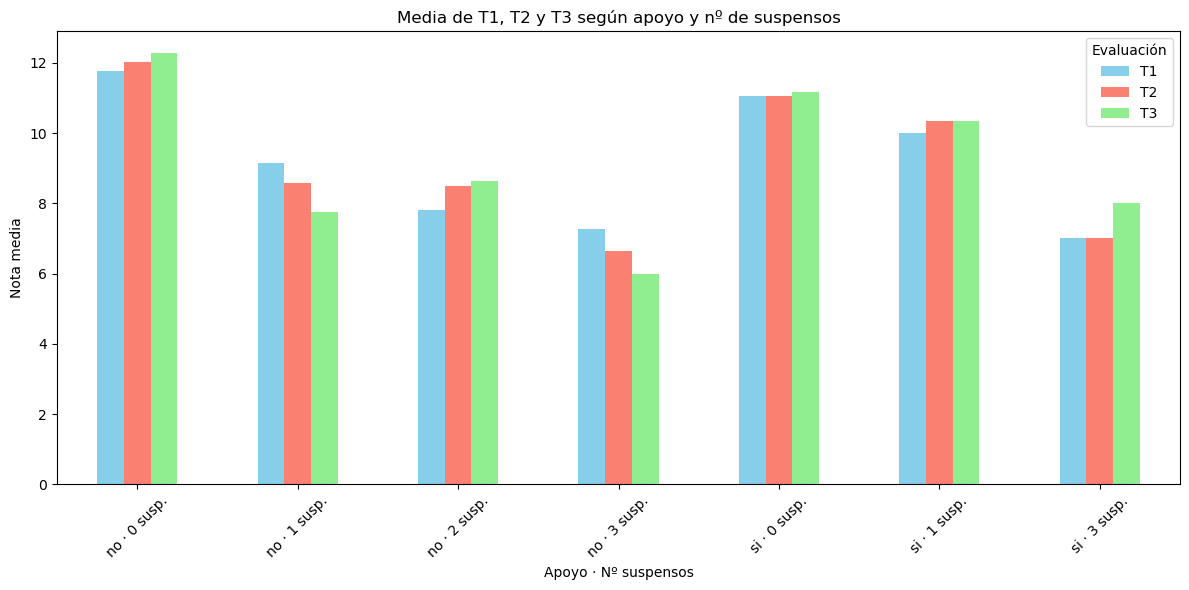

In [33]:
# Agrupar los datos por gente que recibe apoyo y cuantas han suspendido
media_apoyo_susp = (df_balanced.groupby(["apoyo", "suspensos"])[["T1", "T2", "T3"]].mean().sort_index())                 # para que salgan ordenado)


# Etiquetas
media_apoyo_susp.index = [f"{apoyo} · {n_susp} susp." for apoyo, n_susp in media_apoyo_susp.index]

# Hacer el gráfico
media_apoyo_susp.plot(
    kind="bar",
    figsize=(12, 6),
    color=["skyblue", "salmon", "lightgreen"]
                    )

plt.title("Media de T1, T2 y T3 según apoyo y nº de suspensos")
plt.xlabel("Apoyo · Nº suspensos")
plt.ylabel("Nota media")
plt.xticks(rotation=45)
plt.legend(title="Evaluación")
plt.tight_layout()
plt.show()

Luego analizamos como cambian las medias en función del tiempo de viaje hasta la escuela que tiene cada persona, viendo como aquellas personas que necesitan mayor tiempo para llegar, obtienen una peor calificación. Este es un tema complejo ya que al final un largo tiempo entre si ir y volver a la escuela, puede derivar en desmotivación para ir y hasta pereza, reduciendo así las ganas de estudiar tras un largo trayecto.

Por eso era interesante analizar desde el punto de vista de un Director, para ver si se podría proponer algún tema de transporte para todos los alumnos necesitados de esto, buscando conseguir reducir estos tiempos de transporte (si que es verdad que en 2005 era distinto, y ahora Madrid está mucho más optimizado con el metro y demás)

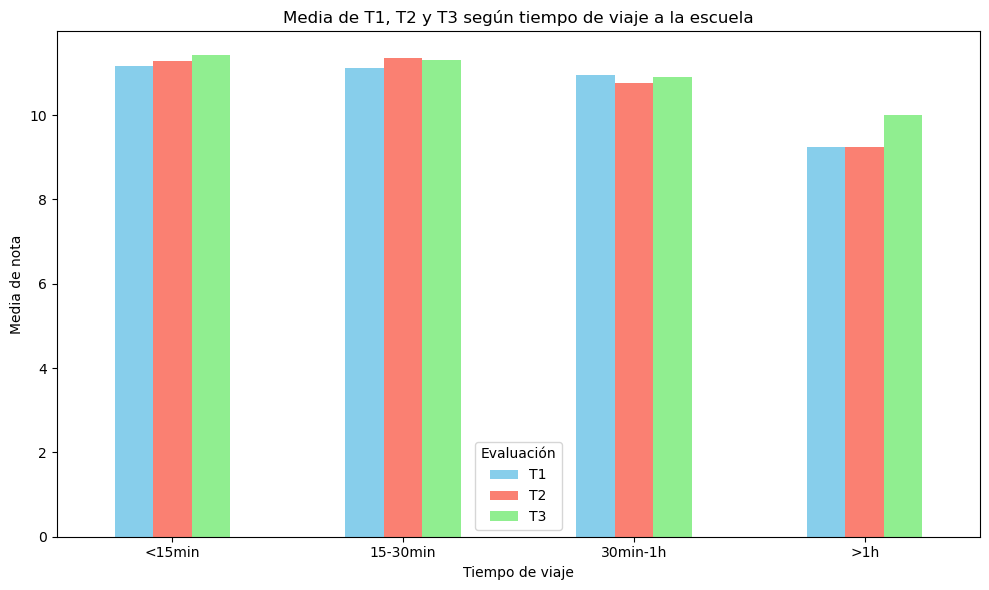

In [34]:
# Calcular medias por tiempo de viaje con el dataset balanceado
media_por_tiempo = df_balanced.groupby("TiempoViaje")[["T1", "T2", "T3"]].mean()

# Diccionario de categorías legibles
viaje_labels = {
    1: "<15min",
    2: "15-30min",
    3: "30min-1h",
    4: ">1h"
}

# Renombrar el índice
media_por_tiempo.index = media_por_tiempo.index.map(viaje_labels)

# Crear el gráfico
media_por_tiempo.plot(kind="bar", figsize=(10, 6), color=["skyblue", "salmon", "lightgreen"])
plt.title("Media de T1, T2 y T3 según tiempo de viaje a la escuela")
plt.xlabel("Tiempo de viaje")
plt.ylabel("Media de nota")
plt.xticks(rotation=0)
plt.legend(title="Evaluación")
plt.tight_layout()
plt.show()

Y por último un tema que era interesante, que sí es cierto que a día de hoy es menos relevante ya que la mayoría de personas por no decir todas tienen acceso a internet, pero me parecía interesante ver como este tema, ya en 2005 tenía su importancia. Viendo como aquellas personas con acceso a internet obtenían mejores calificaciones, detrás de tener internet o no pueden derivar más cosas como trabajo de los padres y demás. Por que, estó antes podría suponer un gasto monetario superior.

Pero me interesaba ver como ya desde 2005, si se notaba quienes tenían acceso a internet pudiendo buscar información o recuesos necesarios para poder estudiar, por tanto así desde Dirección se podría proponer algún sistema de apoyo a estos estudiantes o de proporcionar internet en el Colegio.

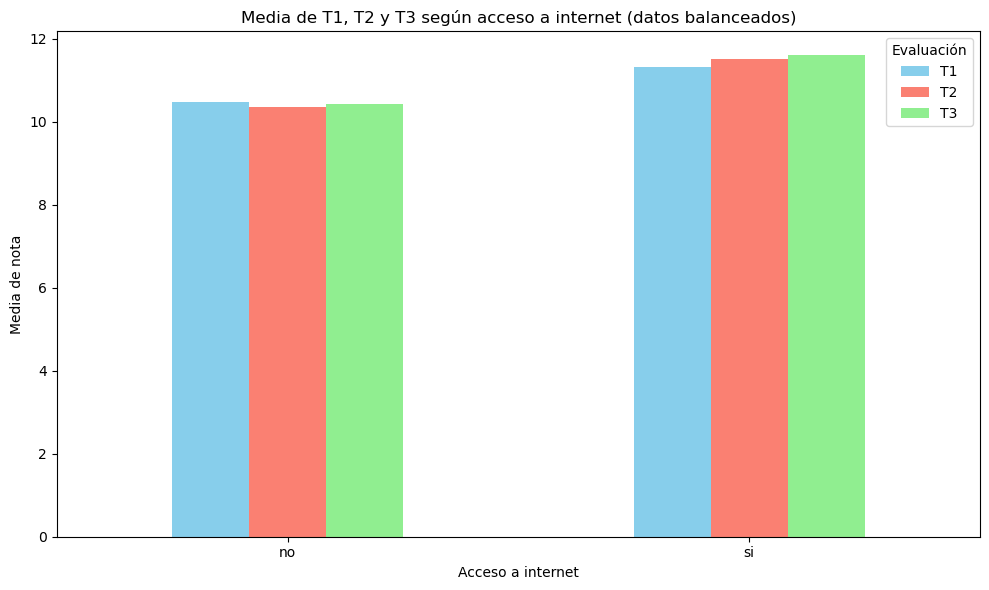

In [35]:
# Calcular medias por acceso a internet con el dataset balanceado
media_por_internet = df_balanced.groupby("internet")[["T1", "T2", "T3"]].mean()

# Crear el gráfico de barras
media_por_internet.plot(kind="bar", figsize=(10, 6), color=["skyblue", "salmon", "lightgreen"])
plt.title("Media de T1, T2 y T3 según acceso a internet (datos balanceados)")
plt.xlabel("Acceso a internet")
plt.ylabel("Media de nota")
plt.xticks(rotation=0)
plt.legend(title="Evaluación")
plt.tight_layout()
plt.show()

## Analisis adicional

Análisis de variables que afectan en las calificaciones orientadas más a la vida social.

Histograma que nos va a mostrar como varian las notas en función del alcohol consumido entre semana, ya que considero que es interesante saberlo. En vista a pensar que es algo independiente que realmente no llega a afectarnos en este tema, pero saber realmente si influye o no.

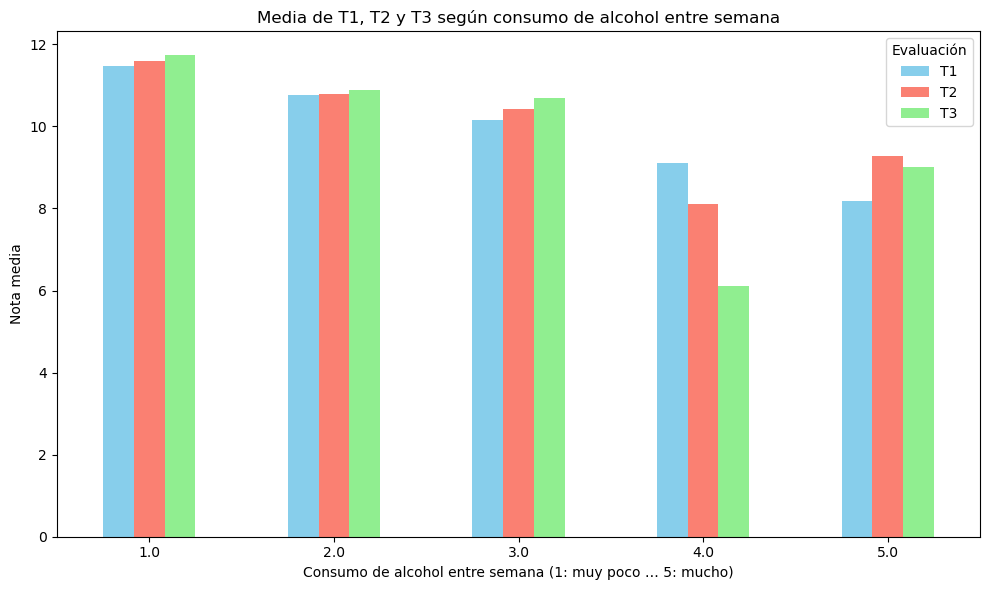

In [36]:
# Calcular medias por consumo de alcohol entre semana (AlcSem)
media_por_alcsem = (
    df_balanced
      .groupby("AlcSem")[["T1", "T2", "T3"]]
      .mean()
)

# Graficar
ax = media_por_alcsem.plot(
    kind="bar",
    figsize=(10, 6),
    color=["skyblue", "salmon", "lightgreen"]
)

# Ajuste de títulos y etiquetas
ax.set_title("Media de T1, T2 y T3 según consumo de alcohol entre semana")
ax.set_xlabel("Consumo de alcohol entre semana (1: muy poco … 5: mucho)")
ax.set_ylabel("Nota media")
ax.legend(title="Evaluación")
ax.set_xticklabels(media_por_alcsem.index, rotation=0)

plt.tight_layout()
plt.show()

Heat-Map de nota media de T3, que nos combinara el tiempo de estudio con el tiempo de salir con amigos después de clase. Para ver que combinaciones nos llevan a intentar obtener mejores resultados, intentado ver si realmente lo mejor es encerrarse y estudiar, encontrando cosas interesantes.

Haciendonos ver como conviene también algún día despejarse y salir con los amigos para relajarnos un poco.

C:\Users\Estudios\AppData\Local\Temp\ipykernel_26364\1572188162.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_study_friends = df.pivot_table(


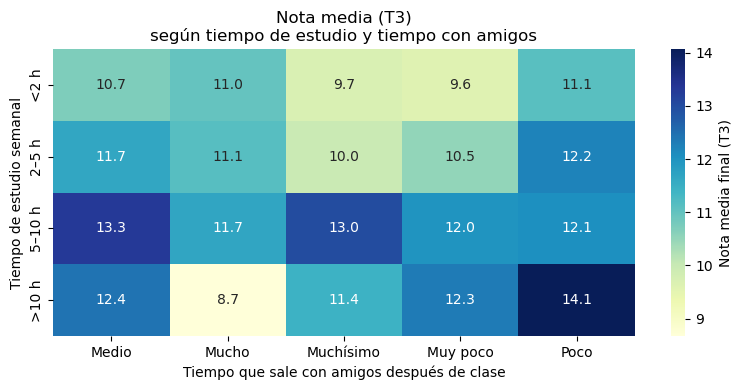

In [37]:
# Categorizar Tiempo de estudio en rangos claros
df["Estudio_bins"] = pd.cut(
    df["TiempoEstudio"].astype(float),
    bins=[0, 1, 2, 3, 4],
    labels=["<2 h", "2–5 h", "5–10 h", ">10 h"],
    include_lowest=True
)

# Mapear Salida con amigos (SalAm) a etiquetas descriptivas
sal_labels = {
    1: "Muy poco",
    2: "Poco",
    3: "Medio",
    4: "Mucho",
    5: "Muchísimo"
}
df["SalAm_cat"] = df["SalAm"].map(sal_labels)

# Pivot table de nota media final (T3)
pivot_study_friends = df.pivot_table(
    values="T3",
    index="Estudio_bins",
    columns="SalAm_cat",
    aggfunc="mean"
)

# heat‑map
plt.figure(figsize=(8, 4))
sns.heatmap(
    pivot_study_friends,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={"label": "Nota media final (T3)"}
)
plt.title("Nota media (T3)\nsegún tiempo de estudio y tiempo con amigos")
plt.xlabel("Tiempo que sale con amigos después de clase")
plt.ylabel("Tiempo de estudio semanal")
plt.tight_layout()
plt.show()


# Exportar datos

Parte comentada para a la hora de ejecutar todo que no nos genere otro.

In [38]:
# # Sup´on que predicciones_modelo1 y predicciones_modelo2 son arrays de numpy o listas
# submission = pd.DataFrame({
# 'Modelo_i': y_pred_capeado_modelo_1,
# 'Modelo_ii': y_pred_capeado_modelo_2
# })
# submission.to_csv('predicciones_finales.csv', index=False)